In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tqdm

from transformers import BertTokenizer
from transformers import BertModel

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
import seaborn as sns

/opt/anaconda3/envs/GemmaASD/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
access_token = ''

In [3]:
from huggingface_hub import login
login(access_token, add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/jeahyukjeong/.cache/huggingface/token
Login successful


In [4]:
# 데이터 불러오기

data_total = pd.read_csv('./output/QCHAT_T_ASD_total_First.csv')
data_total=data_total[['Class/ASD Traits','text']]
data_total.columns = ['ASD_traits', 'text'] # column 이름 전환
data_total.head()

,ASD_traits,text
0,0,", , , , , , , , ,"
1,0,", , , , , , , , ,"
2,0,", , , , , , , , ,"
3,0,", , , , , , , , ,"
4,0,", , , , , , , , ,"


In [5]:
# train-validation-test split

np.random.seed(112)
df_train, df_val, df_test = np.split(data_total.sample(frac=1, random_state=42), 
                                     [int(.8*len(data_total)), int(.9*len(data_total))])

print(len(df_train),len(df_val), len(df_test))
print('train set label counts: ', df_train['ASD_traits'].value_counts())
print('validation set label counts: ', df_val['ASD_traits'].value_counts())
print('test set label counts: ', df_test['ASD_traits'].value_counts())
df_train.head()

123 15 16
train set label counts:  ASD_traits
1    84
0    39
Name: count, dtype: int64
validation set label counts:  ASD_traits
1    13
0     2
Name: count, dtype: int64
test set label counts:  ASD_traits
1    13
0     3
Name: count, dtype: int64


/opt/anaconda3/envs/GemmaASD/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,ASD_traits,text
15,0,", , , , , , , ,difficulty imitating gesture ,..."
94,1,", , , , , , , , ,"
152,1,",contacts eye , , , , ,social interaction imp..."
105,1,", , , ,does pretend play , ,social interactio..."
109,1,", , , ,does pretend play ,shifting attention ..."


In [6]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['TORCH_USE_CUDA_DSA']='0'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
labels = {
        0:0,
        1:1,
          }

class Dataset(Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['ASD_traits']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 16, truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx) # tokenized text with two columns: input_ids, attention_masks
        batch_y = self.get_batch_labels(idx) # label encoded ASD_traits

        return batch_texts, batch_y

In [25]:


# on base Bert model, apply dropout layer, linear(densly connected) layer, and relu layer (for classification task)
class GemmaClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(GemmaClassifier, self).__init__()

        self.gemma = AutoModel.from_pretrained(
            "google/gemma-2-2b",
            device_map="auto",
            torch_dtype=torch.bfloat16,
            )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(2304, 2) # len(labels) =2 ASD YEs or not or 5
        #nn.init.xavier_uniform_(self.linear.weight)
        self.relu = nn.ReLU()

    def forward(self, input, mask):

        pooled_output = self.gemma(input_ids= input, attention_mask=mask,return_dict=False)
        print("shape: ", len(pooled_output))
        pooled_output = pooled_output[0][:, 0, :]
        print("pooled_output: ", pooled_output)
        dropout_output = self.dropout(pooled_output)
        print("dropout_output: ", dropout_output)
        linear_output = self.linear(dropout_output)
        print("linear_output: ", linear_output)
        
        final_layer = self.relu(linear_output)
        
        return final_layer

In [26]:
# Model Training

def train(model, train_data, val_data, learning_rate, epochs):

    mps_device = torch.device("mps")

    # 데이터를 tokenization하고, tensor형태로 바꾸어 사용합니다
    train, val = Dataset(train_data), Dataset(val_data)
    
    # train speed 높이기 위해서 batch_size=2를 이용해 parallel train
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    """
    # use cpu or gpu 
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    print(device)
    """
    criterion = nn.CrossEntropyLoss() # loss function (softmax + NLLLoss)
    optimizer = Adam(model.parameters(), lr= learning_rate) # hyperparater tuning

    # Evaluation
    best_eval_auprc = 0
    best_eval_auroc = 0
    train_auprc_log = []
    eval_auprc_log = []
    train_auroc_log = []
    eval_auroc_log = []
    train_loss_log = []
    eval_loss_log = []
    """
    if use_cuda:

        model = model..to(mps_device)
        criterion = criterion..to(mps_device)
    """
    model = model.to(mps_device)
    criterion = criterion.to(mps_device)

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        preds_train = []
        targets_train = []
        avg_train_loss = 0.

        for train_input, train_label in tqdm.tqdm(train_dataloader):

            train_label = train_label.to(mps_device)

            # separate input_ids and attemtion mask from tokenized train dataset
            mask = train_input['attention_mask'].squeeze(1).to(mps_device) # need to keep shape of (batch_size, seq_length)
            input_id = train_input['input_ids'].squeeze(1).to(mps_device) # need to keep shape of (batch_size, seq_length)

            # Forward Propagation
            output = model(input_id, mask) # train inputs passed through model to get output
            print("output:, ", output)
            print("train_label: ", train_label)
            print("train_label_long: ", train_label.long())
            batch_loss = criterion(output, train_label.long()) # measure loss value from the output
            print("loss_value: ", batch_loss)
            total_loss_train += batch_loss.item() 
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Backward Propagation
            model.zero_grad() # back propagation requires this
            batch_loss.backward() # backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step() # optimize the hyperparameter by using Adam

            avg_train_loss += batch_loss.item() / len(train_dataloader)

            probs_train = output.argmax(dim=1)
            preds_train += list(probs_train.cpu().flatten())
            targets_train += list(train_label.detach().cpu().numpy().flatten())         

        auroc_train = roc_auc_score(targets_train, preds_train) # sklearn auroc matrix 
        auprc_train = average_precision_score(targets_train, preds_train, average='micro') # sklearn auprc matrix       
    
        print('[Train]  loss: {:.3f},  auroc: {:.3f},   auprc: {:.3f}'.format(avg_train_loss, auroc_train, auprc_train))
        train_auprc_log.append(auprc_train)
        train_auroc_log.append(auroc_train)
        train_loss_log.append(avg_train_loss)
            
        total_acc_val = 0
        total_loss_val = 0
        preds_eval = []
        targets_eval = []
        avg_eval_loss = 0.
    
        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(mps_device)
                mask = val_input['attention_mask'].squeeze(1).to(mps_device) # need to keep shape of (batch_size, seq_length)
                input_id = val_input['input_ids'].squeeze(1).to(mps_device) # need to keep shape of (batch_size, seq_length)

                output = model(input_id, mask) # validation inputs passed through the model
                
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

                avg_eval_loss += batch_loss.item() / len(val_dataloader)

                probs_eval  =output.argmax(dim=1)
                #print(f'Prob_T: {probs_test}')
                preds_eval += list(probs_eval.cpu().flatten())
            #print(f'Pred_T: {preds_test}')
                targets_eval += list(val_label.detach().cpu().numpy().flatten())         
            #print(f'Target_T:{targets_test}')
            auroc_eval = roc_auc_score(targets_eval, preds_eval) # sklearn auroc matrix 
            auprc_eval = average_precision_score(targets_eval, preds_eval, average='micro') # sklearn auprc matrix 

        
        print('[Valid]  loss: {:.3f},  auroc: {:.3f},   auprc: {:.3f}'.format(avg_eval_loss, auroc_eval, auprc_eval))
        eval_auprc_log.append(auprc_eval)
        eval_auroc_log.append(auroc_eval)
        eval_loss_log.append(avg_eval_loss)
        
        if best_eval_auprc < auprc_eval:
            best_eval_loss = avg_eval_loss
            best_eval_auroc = auroc_eval
            best_eval_auprc = auprc_eval
        
        print('Training End!')
        print('Best eval auprc ', best_eval_auprc)
        print('Best eval auroc', best_eval_auroc)
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        print(best_eval_loss, best_eval_auroc)

    return best_eval_auprc, best_eval_loss, best_eval_auroc, eval_auprc_log, eval_auroc_log, eval_loss_log


In [27]:
offload_buffers=True
EPOCHS = 5
model = GemmaClassifier()
LR = 1e-8

Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


In [28]:
offload_buffers=True
best_eval_auprc, best_eval_loss, best_eval_auroc, eval_auprc_log, eval_auroc_log, eval_loss_log=train(model, df_train, df_val, LR, EPOCHS)

  0%|          | 0/62 [00:00<?, ?it/s]

shape:  1
pooled_output:  tensor([[ 2.7656, -0.2656,  1.7031,  ..., -6.5625,  0.4121, -0.8750],
        [ 2.7656, -0.2656,  1.7031,  ..., -6.5625,  0.4121, -0.8750]],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)
dropout_output:  tensor([[ 5.5312, -0.0000,  0.0000,  ..., -0.0000,  0.8242, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, -1.7500]],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>)
linear_output:  tensor([[-6.4652e-37, -7.8438e+00],
        [ 9.6369e+36, -4.7188e+00]], device='mps:0', dtype=torch.bfloat16,
       grad_fn=<LinearBackward0>)
output:,  tensor([[0.0000e+00, 0.0000e+00],
        [9.6369e+36, 0.0000e+00]], device='mps:0', dtype=torch.bfloat16,
       grad_fn=<ReluBackward0>)
train_label:  tensor([0, 1], device='mps:0')
train_label_long:  tensor([0, 1], device='mps:0')
loss_value:  tensor(4.8185e+36, device='mps:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)


  0%|          | 0/62 [00:05<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 40.67 GB, other allocations: 4.40 GB, max allowed: 45.90 GB). Tried to allocate 1.10 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
#Evaluate Model on Test Data
print('Training End!') # eval_auprc_log
print('Best eval auprc ', best_eval_auprc) #eval_auprc_log
print('Best eval auroc', best_eval_auroc) # eval_auroc_log
print('Best eval loss', best_eval_loss)

Training End!
Best eval auprc  0.8666666666666667
Best eval auroc 0.5
Best eval loss 4.340435679964437e+33


In [ ]:
# Save the model
torch.save(model.state_dict(), './output/Bert_qchatmodel.pth')

<All keys matched successfully>

In [ ]:
# Load the model
model.load_state_dict(torch.load('./output/Bert_qchatmodel.pth'))

<All keys matched successfully>

pooled_output:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       dtype=torch.bfloat16)
dropout_output:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       dtype=torch.bfloat16)
linear_output:  tensor([[0., nan],
        [0., nan]], device='mps:0', dtype=torch.bfloat16)
pooled_output:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       dtype=torch.bfloat16)
dropout_output:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       dtype=torch.bfloat16)
linear_output:  tensor([[0., nan],
        [0., nan]], device='mps:0', dtype=torch.bfloat16)
pooled_output:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       dtype=torch.bfloat16)
dropout_output:  tensor([[nan, nan, nan,  

/opt/anaconda3/envs/GemmaASD/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


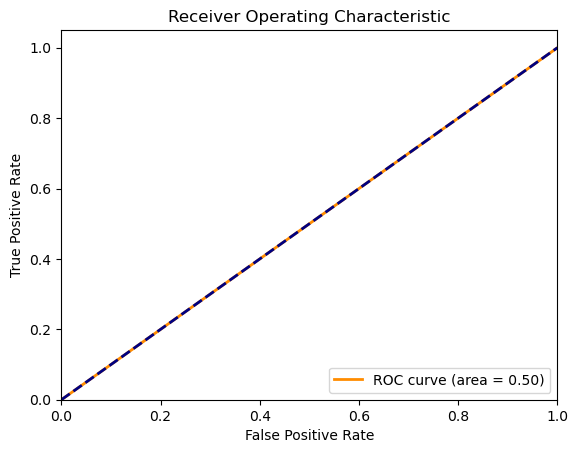

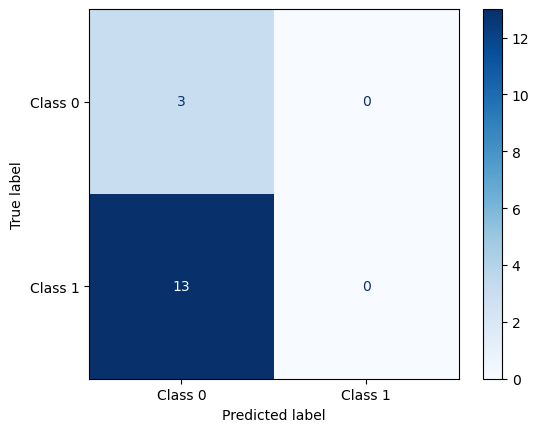

In [ ]:
criterion = nn.CrossEntropyLoss() 
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    mps_device = torch.device("mps")

    model = model.to(mps_device)

    total_acc_test = 0
    preds_test = []
    targets_test = []
    avg_test_loss = 0.
    
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(mps_device)
            #print(f'test_label: {test_label}')
            mask = test_input['attention_mask'].squeeze(1).to(mps_device)
            input_id = test_input['input_ids'].squeeze(1).to(mps_device)

            output = model(input_id, mask)
            #print(f'output : { output }')
            #print(f'output.argmax(dim=1) : { output.argmax(dim=1) }')
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            loss = criterion(output, test_label) #BCELoss, 
            #print(f'LOSS: {loss}')
            avg_test_loss +=   loss.item() / len(test_dataloader)
            #print(f'Avg T LOSS: {avg_test_loss }')

            #probs_test = output.detach().cpu().numpy()
            probs_test =output.argmax(dim=1)
            #print(f'Prob_T: {probs_test}')
            preds_test += list(probs_test.cpu().flatten())
            #print(f'Pred_T: {preds_test}')
            targets_test += list(test_label.detach().cpu().numpy().flatten())         
            #print(f'Target_T:{targets_test}')

        precision, recall, f1, _ = precision_recall_fscore_support(targets_test, preds_test, average='binary')
        acc = accuracy_score(targets_test, preds_test)
        print(f'f1: {f1}')
        #pr_curve = PrecisionRecallCurve(num_classes=2)
        #precision, recall, thresholds = pr_curve(preds_test, targets_test)
        auroc_test = roc_auc_score(targets_test, preds_test)
        print(auroc_test )
        #print(targets_test, preds_test)
        #auprc_test = average_precision_score(targets_test, preds_test, average='micro')   
        #print(auprc_test)
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print( precision, recall,  f1 )


        # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(targets_test, preds_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(targets_test, preds_test)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# evaluate(model, df_test)
    
evaluate(model, df_test)

In [ ]:
x = np.arange(0,50) #config.n_epoch : 50

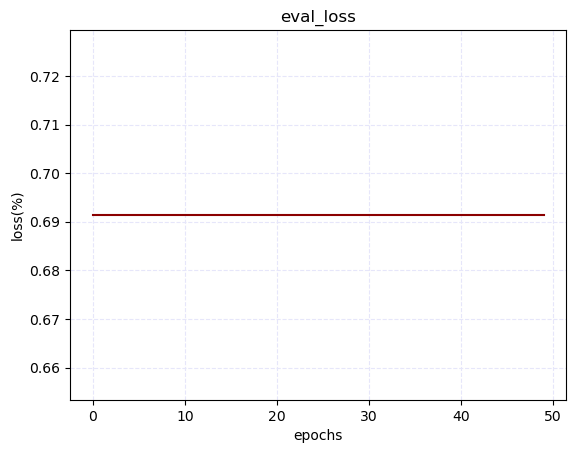

In [ ]:
    # 도화지 생성
    fig = plt.figure()
    # 정확도 그래프 그리기
    plt.plot(x,eval_loss_log, label='eval_loss', color='darkred')
     # 축 이름
    plt.xlabel('epochs')
    plt.ylabel('loss(%)')
    plt.title('eval_loss')
    plt.grid(linestyle='--', color='lavender')
     # 그래프 표시
    plt.show()